# Notebook to analyze downloaded gridded climate time-series data 

### Case study:  the Sauk-Suiattle Watershed
<img src="http://www.sauk-suiattle.com/images/Elliott.jpg" 
style="float:right;width:150px;padding:20px">

### Use this Jupyter Notebook to:
    1. HydroShare setup and preparation
    2. Re-establish the paths to the mapping file
    3. Compute daily, monthly, and annual temperature and precipitation statistics
    4. Visualize precipitation results relative to the forcing data
    5. Visualize the time-series trends
    6. Save results back into HydroShare

<br/><br/><br/>
<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png"
style="float:right;width:150px;padding:20px">

<br/><br/>
#### This data is compiled to digitally observe the watersheds, powered by HydroShare. <br/>Provided by the Watershed Dynamics Group, Dept. of Civil and Environmental Engineering, University of Washington

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [1]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
import ogh
import geopandas as gpd

# data migration library
from utilities import hydroshare

# plotting and shape libraries
%matplotlib inline

# silencing warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [3]:
sorted(meta_file['dailymet_livneh2013'].keys())

['decision_steps',
 'delimiter',
 'domain',
 'end_date',
 'file_format',
 'filename_structure',
 'reference',
 'spatial_resolution',
 'start_date',
 'subdomain',
 'temporal_resolution',
 'variable_info',
 'variable_list',
 'web_protocol']

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [4]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)
print('Data will be loaded from and save to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 70b977e22af544f8a7e5a803935c329c
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong
Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

For visualization purposes, we will also remap the study site shapefile, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. Since the shapefile was previously migrated, we can select 'N' for no overwriting.

In the usecase1 notebook, the treatgeoself function identified the gridded cell centroid coordinates that overlap with our study site. These coordinates were documented within the mapping file, which will be remapped here. In the usecase2 notebook, the downloaded files were cataloged within the mapping file, so we will use the mappingfileSummary function to characterize the files available for Sauk-Suiattle for each gridded data product.

In [5]:
"""
Sauk
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhub12_17110006_WGS84_Basin.shp']

# reproject the shapefile into WGS84
ogh.reprojShapefile(sourcepath=sauk)

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


### Summarize the file availability from each watershed mapping file

In [6]:
# map the mappingfiles from usecase1
mappingfile1 = os.path.join(homedir,'Sauk_mappingfile.csv')

t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1], 
                            listofwatershednames = ['Sauk-Suiattle river'],
                            meta_file=meta_file)

t1

Watershed,Sauk-Suiattle river
Median elevation in meters [range](No. gridded cells),1171[164-2216] (n=99)
dailymet_livneh2013,1171[164-2216] (n=99)
dailymet_bclivneh2013,1171[164-2216] (n=99)
dailymet_livneh2015,1171[164-2216] (n=99)
dailyvic_livneh2013,1171[164-2216] (n=99)
dailyvic_livneh2015,1171[164-2216] (n=99)
dailywrf_salathe2014,1171[164-2216] (n=99)
dailywrf_bcsalathe2014,1171[164-2216] (n=99)


## 3.  Compare Hydrometeorology 

This section performs computations and generates plots of the Livneh 2013 and Salathe 2014 mean temperature and mean total monthly precipitation in order to compare them with each other. The generated plots are automatically downloaded and saved as .png files within the "homedir" directory.

Let's compare the Livneh 2013 and Salathe 2014 using the period of overlapping history.

In [7]:
# Livneh et al., 2013
dr1 = meta_file['dailymet_livneh2013']

# Salathe et al., 2014
dr2 = meta_file['dailywrf_salathe2014']

# define overlapping time window
dr = ogh.overlappingDates(date_set1=tuple([dr1['start_date'], dr1['end_date']]), 
                          date_set2=tuple([dr2['start_date'], dr2['end_date']]))
dr

('1950-01-01', '2010-12-31')

### Create a dictionary of climate variables for the long-term mean (ltm).
#### INPUT: gridded meteorology ASCII files located from the Sauk-Suiattle Mapping file. The inputs to gridclim_dict() include the folder location and name of the hydrometeorology data, the file start and end, the analysis start and end, and the elevation band to be included in the analsyis (max and min elevation). <br/>OUTPUT: dictionary of dataframes where rows are temporal summaries and columns are spatial summaries

In [8]:
%%time
ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        dataset='dailymet_livneh2013',
                        file_time_step=dr1['temporal_resolution'],
                        file_start_date=dr1['start_date'],
                        file_end_date=dr1['end_date'],
                        subset_start_date=dr[0],
                        subset_end_date=dr[1])

Number of data files within elevation range (164.0:2216.0): 99
PRECIP dataframe reading to start: 0:00:00.153111
PRECIP dataframe reading complete:0:00:01.557304
TMAX dataframe reading to start: 0:00:01.707872
TMAX dataframe reading complete:0:00:02.705871
TMIN dataframe reading to start: 0:00:02.855142
TMIN dataframe reading complete:0:00:03.871749
WINDSPD dataframe reading to start: 0:00:04.023739
WINDSPD dataframe reading complete:0:00:05.025979
PRECIP_dailymet_livneh2013 calculations completed in 0:00:00.096008
TMAX_dailymet_livneh2013 calculations completed in 0:00:00.085223
TMIN_dailymet_livneh2013 calculations completed in 0:00:00.084972
WINDSPD_dailymet_livneh2013 calculations completed in 0:00:00.085201
CPU times: user 13 s, sys: 2.65 s, total: 15.6 s
Wall time: 5.39 s


### Compute the total monthly and yearly precipitation, as well as the mean values across time and across stations
#### INPUT: daily precipitation for each station from the long-term mean dictionary (ltm) <br/>OUTPUT: Append the computed dataframes and values into the ltm dictionary

In [9]:
# compute sums and mean monthly an yearly sums
ltm = ogh.aggregate_space_time_sum(df_dict=ltm,
                                   suffix='PRECIP_dailymet_livneh2013',
                                   start_date=dr[0],
                                   end_date=dr[1])

In [10]:
# print the name of dataframes and values within the ltm dictionary
sorted(ltm.keys())

['PRECIP_dailymet_livneh2013',
 'TMAX_dailymet_livneh2013',
 'TMIN_dailymet_livneh2013',
 'WINDSPD_dailymet_livneh2013',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_TMAX_dailymet_livneh2013',
 'anom_year_TMIN_dailymet_livneh2013',
 'anom_year_WINDSPD_dailymet_livneh2013',
 'meanallmonthsum_PRECIP_dailymet_livneh2013',
 'meanallyear_PRECIP_dailymet_livneh2013',
 'meanallyear_TMAX_dailymet_livneh2013',
 'meanallyear_TMIN_dailymet_livneh2013',
 'meanallyear_WINDSPD_dailymet_livneh2013',
 'meanallyearsum_PRECIP_dailymet_livneh2013',
 'meanbymonthsum_PRECIP_dailymet_livneh2013',
 'meanbyyearsum_PRECIP_dailymet_livneh2013',
 'meandaily_PRECIP_dailymet_livneh2013',
 'meandaily_TMAX_dailymet_livneh2013',
 'meandaily_TMIN_dailymet_livneh2013',
 'meandaily_WINDSPD_dailymet_livneh2013',
 'meandailysum_PRECIP_dailymet_livneh2013',
 'meanmonth_PRECIP_dailymet_livneh2013',
 'meanmonth_TMAX_dailymet_livneh2013',
 'meanmonth_TMIN_dailymet_livneh2013',
 'meanmonth_WINDSPD_dailymet_livneh2013',

## Repeat spatial-temporal computations with Salathe et al 2014 WRF data

In [11]:
%%time
ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        dataset='dailywrf_salathe2014',
                        file_time_step=dr2['temporal_resolution'],
                        file_start_date=dr2['start_date'],
                        file_end_date=dr2['end_date'],
                        subset_start_date=dr[0],
                        subset_end_date=dr[1],
                        df_dict=ltm)

# compute sums and mean monthly an yearly sums
ltm = ogh.aggregate_space_time_sum(df_dict=ltm,
                                   suffix='PRECIP_dailywrf_salathe2014',
                                   start_date=dr[0],
                                   end_date=dr[1])

Number of data files within elevation range (164.0:2216.0): 99
PRECIP dataframe reading to start: 0:00:00.152166
PRECIP dataframe reading complete:0:00:01.162268
TMAX dataframe reading to start: 0:00:01.316334
TMAX dataframe reading complete:0:00:02.260867
TMIN dataframe reading to start: 0:00:02.410308
TMIN dataframe reading complete:0:00:03.349091
WINDSPD dataframe reading to start: 0:00:03.500130
WINDSPD dataframe reading complete:0:00:04.615681
PRECIP_dailywrf_salathe2014 calculations completed in 0:00:00.089454
TMAX_dailywrf_salathe2014 calculations completed in 0:00:00.084625
TMIN_dailywrf_salathe2014 calculations completed in 0:00:00.085139
WINDSPD_dailywrf_salathe2014 calculations completed in 0:00:00.084484
CPU times: user 8.89 s, sys: 1.14 s, total: 10 s
Wall time: 5.18 s


In [12]:
# initialize list of outputs
files=[]

# create the destination path for the dictionary of dataframes
ltm_sauk=os.path.join(homedir, 'ltm_sauk.json')
ogh.saveDictOfDf(dictionaryObject=ltm, outfilepath=ltm_sauk)
files.append(ltm_sauk)

# append the mapping file for Sauk-Suiattle gridded cell centroids
files.append(mappingfile1)

In [13]:
# print the name of the Livneh et al. 2013 raw MET and Salathe et al. 2014 raw WRF dataframes and values within ltm
sorted(ltm.keys())

['PRECIP_dailymet_livneh2013',
 'PRECIP_dailywrf_salathe2014',
 'TMAX_dailymet_livneh2013',
 'TMAX_dailywrf_salathe2014',
 'TMIN_dailymet_livneh2013',
 'TMIN_dailywrf_salathe2014',
 'WINDSPD_dailymet_livneh2013',
 'WINDSPD_dailywrf_salathe2014',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_PRECIP_dailywrf_salathe2014',
 'anom_year_TMAX_dailymet_livneh2013',
 'anom_year_TMAX_dailywrf_salathe2014',
 'anom_year_TMIN_dailymet_livneh2013',
 'anom_year_TMIN_dailywrf_salathe2014',
 'anom_year_WINDSPD_dailymet_livneh2013',
 'anom_year_WINDSPD_dailywrf_salathe2014',
 'meanallmonthsum_PRECIP_dailymet_livneh2013',
 'meanallmonthsum_PRECIP_dailywrf_salathe2014',
 'meanallyear_PRECIP_dailymet_livneh2013',
 'meanallyear_PRECIP_dailywrf_salathe2014',
 'meanallyear_TMAX_dailymet_livneh2013',
 'meanallyear_TMAX_dailywrf_salathe2014',
 'meanallyear_TMIN_dailymet_livneh2013',
 'meanallyear_TMIN_dailywrf_salathe2014',
 'meanallyear_WINDSPD_dailymet_livneh2013',
 'meanallyear_WINDSPD_dailywrf_salat

### Visualize the "average daily precipitation by month" and the "total monthly precipitations"

#### INPUT: dataframe with each month as a row and each station as a column. <br/>OUTPUT: A png file that represents the distribution across stations (in Wateryear order)

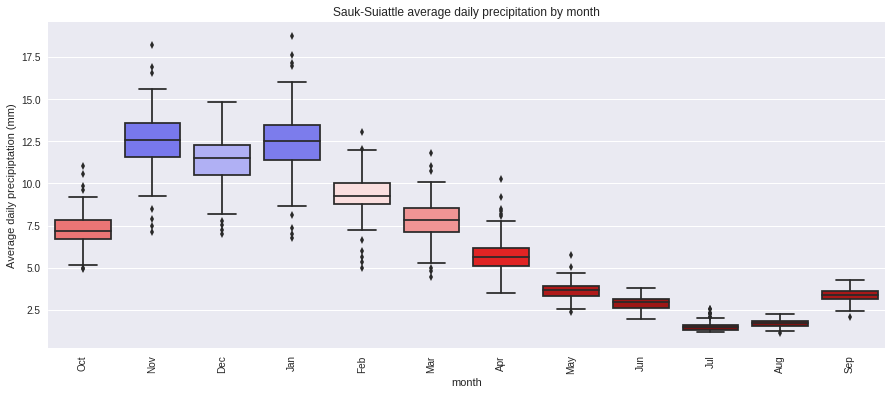

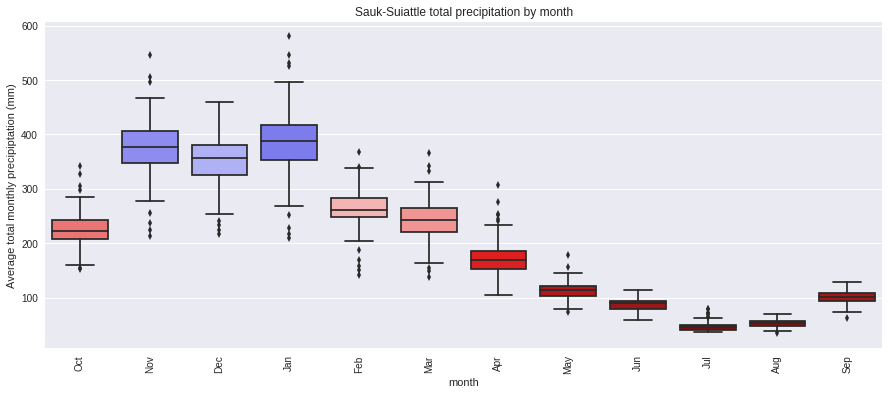

In [14]:
# plot the distribution of average daily precipitation values by month across stations
outfile=os.path.join(homedir, 'monthlyprecip_liv_bx.png')
files.append(outfile)
ax1 = ogh.renderValueInBoxplot(vardf=ltm['month_PRECIP_dailymet_livneh2013'],
                               vmin=ltm['month_PRECIP_dailymet_livneh2013'].as_matrix().min(),
                               vmax=ltm['month_PRECIP_dailymet_livneh2013'].as_matrix().max(),
                               outfilepath=outfile,
                               plottitle='Sauk-Suiattle average daily precipitation by month',
                               time_steps='month',
                               wateryear=True,
                               value_name='Average daily precipiptation (mm)',
                               cmap='seismic_r',
                               figsize=(15,6))

# plot the distribution of total monthly precipitation by month across stations
outfile=os.path.join(homedir, 'meanbymonthsumprecip_liv_bx.png')
files.append(outfile)
ax1 = ogh.renderValueInBoxplot(vardf=ltm['meanbymonthsum_PRECIP_dailymet_livneh2013'],
                               vmin=ltm['meanbymonthsum_PRECIP_dailymet_livneh2013'].as_matrix().min(),
                               vmax=ltm['meanbymonthsum_PRECIP_dailymet_livneh2013'].as_matrix().max(),
                               outfilepath=outfile,
                               plottitle='Sauk-Suiattle total precipitation by month',
                               time_steps='month',
                               wateryear=True,
                               value_name='Average total monthly precipiptation (mm)',
                               cmap='seismic_r',
                               figsize=(15,6))

In [15]:
# # loop through even months in the water year
# for ind, eachmonth in enumerate([10, 1, 4, 7]):
    
#     monthlabel = pd.datetime.strptime(str(eachmonth), '%m')
#     outfile=os.path.join(homedir, 'SaukLivPrecip_{0}.png'.format(monthlabel.strftime('%b')))
#     files.append(outfile)
#     ogh.renderValuesInPoints(vardf=ltm['meanbymonthsum_PRECIP_dailymet_livneh2013'], 
#                              vardf_dateindex=eachmonth,
#                              shapefile=sauk,
#                              outfilepath=outfile,
#                              plottitle='Sauk-Suiattle watershed\nAverage total monthly Precipitation in '+ monthlabel.strftime('%B'),
#                              colorbar_label='Average total monthly precipitation (mm)',
#                              spatial_resolution=1/16, margin=0.5, epsg=3857,
#                              basemap_image='ESRI_Imagery_World_2D',
#                              cmap='seismic_r')

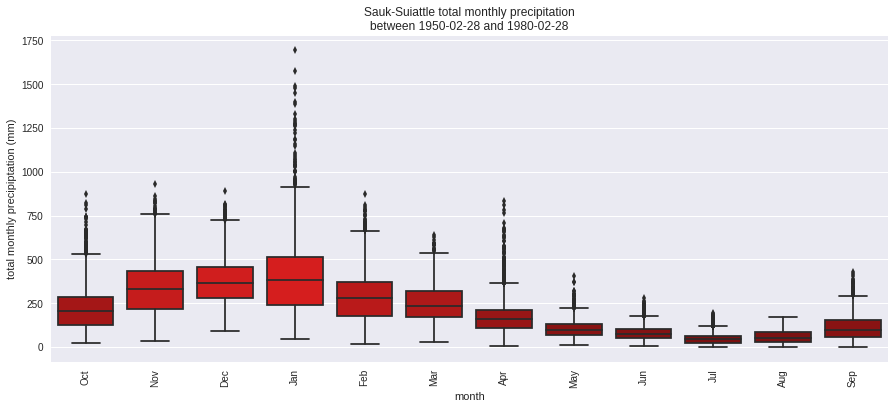

In [18]:
# plot the distribution of total monthly precipitation within a subset date range

# subset to a certain period
temp_df = ltm['monthsum_PRECIP_dailymet_livneh2013'].loc['1950-02-28':'1980-02-28',:]

outfile=os.path.join(homedir, 'monthlysumprecip_subset_bx.png')
files.append(outfile)

ax1 = ogh.renderValueInBoxplot(vardf=temp_df,
                               outfilepath=outfile,
                               plottitle='Sauk-Suiattle total monthly precipitation\nbetween 1950-02-28 and 1980-02-28',
                               time_steps='month',
                               wateryear=True,
                               value_name='total monthly precipiptation (mm)',
                               cmap='seismic_r',
                               vmin=temp_df.as_matrix().min(),
                               vmax=temp_df.as_matrix().max(),
                               figsize=(15,6))

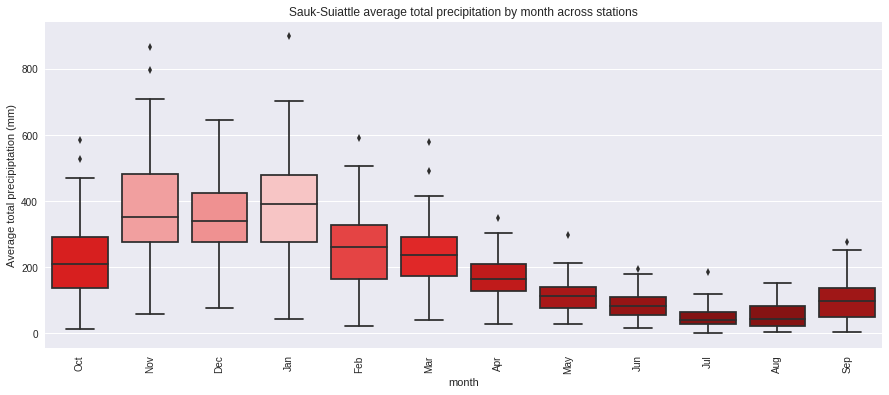

In [20]:
# plot the distribution of average total monthly precipitation across stations
# each datapoint signifies a month-year value
outfile=os.path.join(homedir, 'meanmonthsumprecip_bx.png')
files.append(outfile)
ax1 = ogh.renderValueInBoxplot(vardf=pd.DataFrame(ltm['meanmonthsum_PRECIP_dailymet_livneh2013']),
                               vmin=ltm['meanmonthsum_PRECIP_dailymet_livneh2013'].as_matrix().min(),
                               vmax=ltm['meanmonthsum_PRECIP_dailymet_livneh2013'].as_matrix().max(),
                               outfilepath=outfile,
                               plottitle='Sauk-Suiattle average total precipitation by month across stations',
                               time_steps='month',
                               wateryear=True,
                               value_name='Average total precipiptation (mm)',
                               cmap='seismic_r',
                               figsize=(15,6))

### Visualize the "average daily precipitation by year" and the "total annual precipitation"

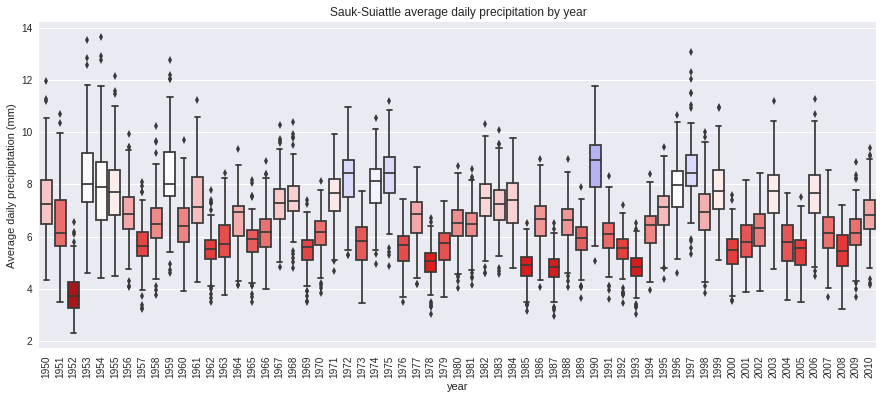

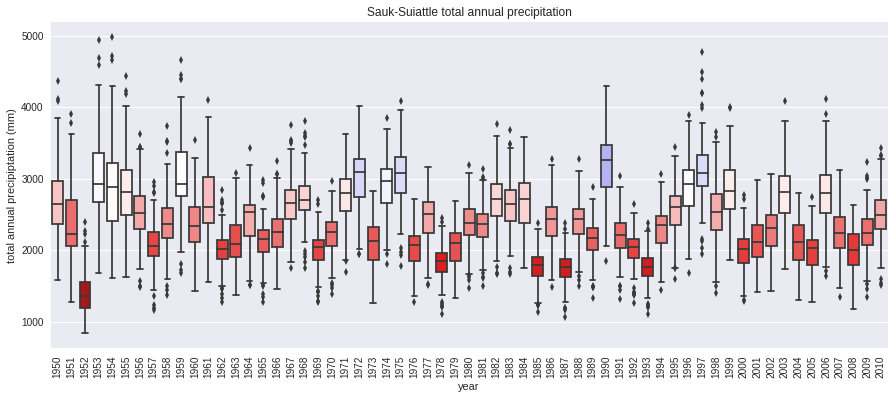

In [21]:
# yearly boxplots
outfile=os.path.join(homedir, 'yearlyprecip_liv_bx.png')
files.append(outfile)
ogh.renderValueInBoxplot(vardf=ltm['year_PRECIP_dailymet_livneh2013'],
                         outfilepath=outfile,
                         plottitle='Sauk-Suiattle average daily precipitation by year',
                         time_steps='year',
                         value_name='Average daily precipiptation (mm)',
                         cmap='seismic_r',
                         figsize=(15,6))

outfile=os.path.join(homedir, 'meanyearsumprecip_liv_bx.png')
files.append(outfile)
ogh.renderValueInBoxplot(vardf=ltm['yearsum_PRECIP_dailymet_livneh2013'],
                         outfilepath=outfile,
                         plottitle='Sauk-Suiattle total annual precipitation',
                         time_steps='year',
                         value_name='total annual precipiptation (mm)',
                         cmap='seismic_r',
                         figsize=(15,6))

In [ ]:
# visualize the annual precipitation within years of historic highs and lows

for year in [1952, 1953, 1990, 1997, 2006, 2008]:
    
    outfile=os.path.join(homedir, 'SaukLivPrecip{0}.png'.format(year))
    files.append(outfile)
    ogh.renderValuesInPoints(vardf=ltm['yearsum_PRECIP_dailymet_livneh2013'], 
                             vardf_dateindex=year,
                             shapefile=sauk,
                             outfilepath=outfile,
                             plottitle='Sauk-Suiattle watershed\nTotal annual precipitation in '+ str(year),
                             colorbar_label='Total annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.5, epsg=3857,
                             basemap_image='ESRI_Imagery_World_2D',
                             cmap='seismic_r')

## 4. Visualize the comparison to WRF data from Salathe et al., 2014

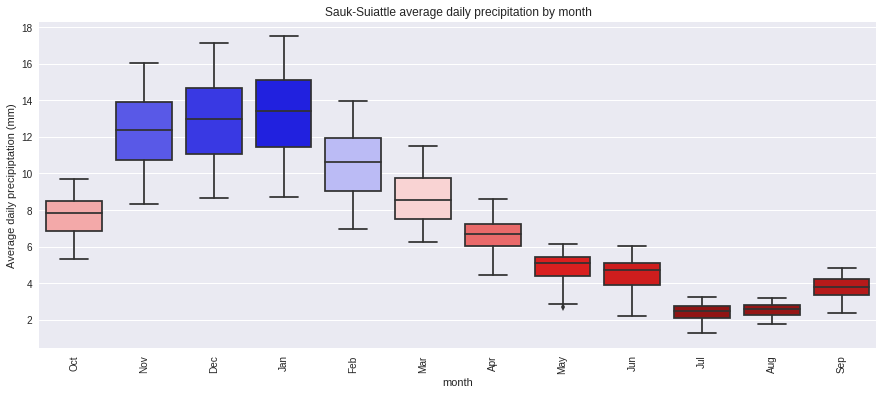

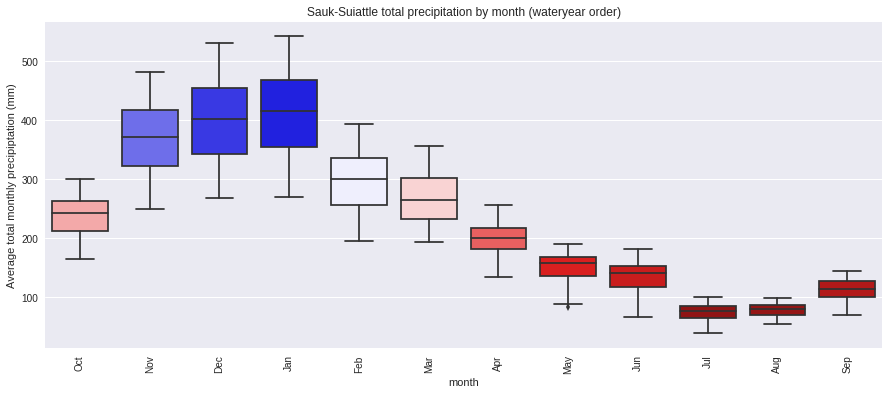

In [22]:
# plot the distribution of average daily precipitation by month
outfile=os.path.join(homedir, 'monthlyprecip_wrf_bx.png')
files.append(outfile)
ogh.renderValueInBoxplot(vardf=ltm['month_PRECIP_dailywrf_salathe2014'],
                         vmin=ltm['month_PRECIP_dailywrf_salathe2014'].as_matrix().min(),
                         vmax=ltm['month_PRECIP_dailywrf_salathe2014'].as_matrix().max(),
                         outfilepath=outfile,
                         plottitle='Sauk-Suiattle average daily precipitation by month',
                         time_steps='month',
                         wateryear=True,
                         value_name='Average daily precipiptation (mm)',
                         cmap='seismic_r',
                         figsize=(15,6))


# plot the distribution of average total monthly precipitation by month
outfile=os.path.join(homedir, 'meanbymonthsumprecip_wrf_bx.png')
files.append(outfile)
ogh.renderValueInBoxplot(vardf=ltm['meanbymonthsum_PRECIP_dailywrf_salathe2014'],
                         vmin=ltm['meanbymonthsum_PRECIP_dailywrf_salathe2014'].as_matrix().min(),
                         vmax=ltm['meanbymonthsum_PRECIP_dailywrf_salathe2014'].as_matrix().max(),
                         outfilepath=outfile,
                         plottitle='Sauk-Suiattle total precipitation by month (wateryear order)',
                         time_steps='month',
                         wateryear=True,
                         value_name='Average total monthly precipiptation (mm)',
                         cmap='seismic_r',
                         figsize=(15,6))

In [ ]:
# # loop through even months in the water year
# for ind, eachmonth in enumerate([10, 1, 4, 7]):
    
#     monthlabel = pd.datetime.strptime(str(eachmonth), '%m')
#     outfile=os.path.join(homedir, 'SaukWRFPrecip_{0}.png'.format(monthlabel.strftime('%b')))
#     files.append(outfile)
#     ogh.renderValuesInPoints(vardf=ltm['meanbymonthsum_PRECIP_dailywrf_salathe2014'],
#                              vardf_dateindex=eachmonth,
#                              shapefile=sauk,
#                              outfilepath=outfile,
#                              plottitle='Sauk-Suiattle watershed'+'\nAverage total monthly precipitation in '+ monthlabel.strftime('%B'),
#                              colorbar_label='Average total monthly precipitation (mm)',
#                              spatial_resolution=1/16, margin=0.5, epsg=3857,
#                              basemap_image='ESRI_Imagery_World_2D',
#                              cmap='seismic_r')

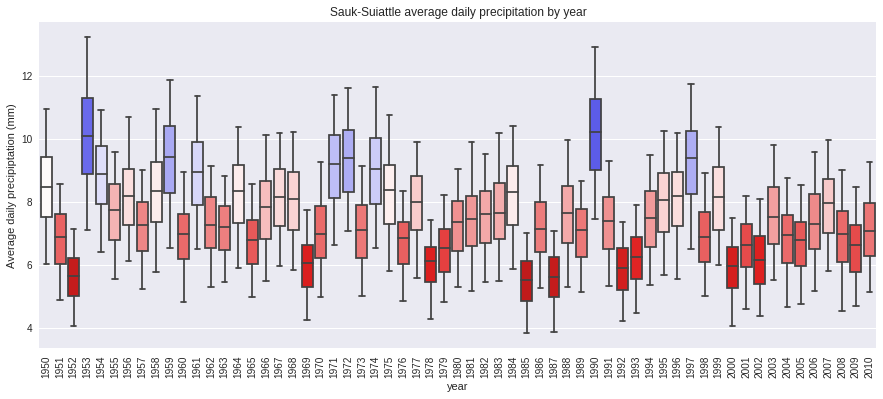

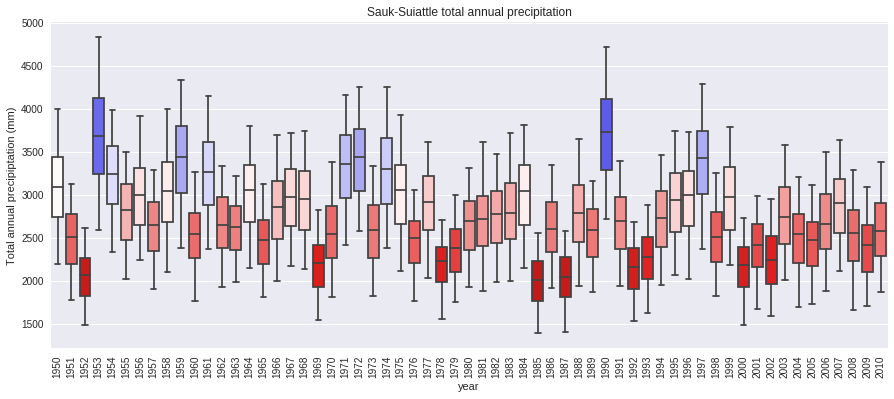

In [23]:
# yearly boxplots
outfile=os.path.join(homedir, 'yearlyprecip_wrf_bx.png')
files.append(outfile)
ogh.renderValueInBoxplot(vardf=ltm['year_PRECIP_dailywrf_salathe2014'],
                         outfilepath=outfile,
                         plottitle='Sauk-Suiattle average daily precipitation by year',
                         time_steps='year',
                         value_name='Average daily precipiptation (mm)',
                         cmap='seismic_r',
                         figsize=(15,6))


outfile=os.path.join(homedir, 'yearsumprecip_wrf_bx.png')
files.append(outfile)
ogh.renderValueInBoxplot(vardf=ltm['yearsum_PRECIP_dailywrf_salathe2014'],
                         outfilepath=outfile,
                         plottitle='Sauk-Suiattle total annual precipitation',
                         time_steps='year',
                         value_name='Total annual precipiptation (mm)',
                         cmap='seismic_r',
                         figsize=(15,6))

## 5. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

### Total files and image to migrate

In [24]:
len(files)

15

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Computed spatial-temporal summaries of two gridded data product data sets for Sauk-Suiattle'
abstract = 'This resource contains the computed summaries for the Meteorology data from Livneh et al. 2013 and the WRF data from Salathe et al. 2014.'
keywords = ['Sauk-Suiattle', 'Livneh 2013', 'Salathe 2014','climate','hydromet','watershed', 'visualizations and summaries'] 
rtype = 'genericresource'

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)